# 2D hexagonal boron nitride (hBN) benchmark

# Define config and template

In [1]:
#change password, username  REMOTE_WORKING_DIR REMOTE_SCRATCH_DIR to yours
ssh_config = {'hostname': 'midway2.rcc.uchicago.edu',
          'port': 22,
          'timeout': 30,
          'username': 'huangl1',
          'password': '',
          'multi_factor_auth': 'yes',
          'multi_factor_auth_key': 'Duo',
          'multi_factor_auth_option': '1',

          'REMOTE_WORKING_DIR': '/home/huangl1/simulation',
          'REMOTE_SCRATCH_DIR': '/home/huangl1/scratch-midway2/simulation/BN_benchmark',

          'log_file': 'log.pickle',

          'cmd_job_status': 'squeue -u huangl1',
          'cmd_job_submit': 'sbatch',
          'cmd_job_cancel': 'scancel',

          'job_status_header_skip': 1,
          'job_status_jobid_col': 1,
          'job_status_st_col': 5,
          'job_status_pending_label': 'PD',
          'job_status_running_label': 'R',
          'job_status_time_col': 6}

rcc_template_string = """#!/bin/bash
#SBATCH --job-name={{job_name}}
#SBATCH --time={{time}}
#SBATCH --partition={{queue}}
#SBATCH --nodes={{nodes}}
#SBATCH --ntasks-per-node={{ntasks_per_node}}
#SBATCH --cpus-per-task={{cpus_per_task}}
#SBATCH --mem-per-cpu={{mem_per_cpu}}

module purge
module load intelmpi/5.1+intel-16.0 mkl/2017.up4 Anaconda3/5.1.0

export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
NTASKS=$(($SLURM_NTASKS_PER_NODE * $SLURM_JOB_NUM_NODES))

{{cmd}}


"""
from ezjob import *
from westpy import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


  ______ _____ _       _
 |  ____|___  (_)     | |
 | |__     / / _  ___ | |__   
 |  __|   / / | |/ _ \| '_ \    
 | |____ / /__| | (_) | |_) |     
 |______/_____| |\___/|_.__/     
             _/ |
            |__/
   
Job Manager version :    0.1.8
Today :    2020-07-27 16:33:42
 
 _    _ _____ _____ _____            
| |  | |  ___/  ___|_   _|           
| |  | | |__ \ `--.  | |_ __  _   _  
| |/\| |  __| `--. \ | | '_ \| | | | 
\  /\  / |___/\__/ / | | |_) | |_| | 
 \/  \/\____/\____/  \_/ .__/ \__, | 
                       | |     __/ | 
                       |_|    |___/  
 
WEST version     :  4.2.0
Today            :  2020-07-27 16:33:43.290840


# connect ssh

In [2]:
ssh = SSH(ssh_config,'rcc')
ssh.connect()

Password:
Duo two-factor login for huangl1

Enter a passcode or select one of the following options:

 1. Duo Push to XXX-XXX-4177
 2. Phone call to XXX-XXX-4177
 3. SMS passcodes to XXX-XXX-4177

Passcode or option (1-3):
Success. Logging you in...
Last login: Sun Jul 26 03:44:45 2020 from c-73-51-208-105.hsd1.il.comcast.net
                               Welcome to Midway
                           Research Computing Center
                             University of Chicago
                            http://rcc.uchicago.edu


For the RCC Manual see the documentation site at
    http://docs.rcc.uchicago.edu

To check your allocation balance for the current period use this command:
accounts balance

Questions and issues should be sent to help@rcc.uchicago.edu or 773-795-2667.

*******************************************************************************

Midway information system usage may be monitored, recorded, and subject to audit.
Use of the information system indicates consent 

In [3]:
jm = JobManager(ssh)

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc


# hBN geom creation & relax

In [9]:
jm.cd_LOCAL_WORKING_DIR()

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc


In [10]:
#%mkdir relax
%cd relax

/home/lan/Desktop/hBN_benchmark/rcc/relax


In [19]:
import numpy as np
from westpy.units import Angstrom
A2BOHR  = Angstrom
BOHR2A = 1.0 / Angstrom

geom = Geometry()
#define unit cell
#>>    ibrav = 4           ,
#>>    celldm(1) = 4.695926777902829 ,
#>>    celldm(3) = 8.048362859199854 ,
# 4     Hexagonal and Trigonal P   celldm(3)=c/a
#       v1 = a(1,0,0),  v2 = a(-1/2,sqrt(3)/2,0),  v3 = a(0,0,c/a)
#https://materialsproject.org/materials/mp-984/
celldm_1 = 2.51242804*A2BOHR         #bohr
celldm_3 = 7.70726501/2.0/2.512      #c/a
geom.addSpecies( "B", "http://www.quantum-simulation.org/potentials/sg15_oncv/upf/B_ONCV_PBE-1.2.upf")
geom.addSpecies( "N", "http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N_ONCV_PBE-1.2.upf")
geom.setCell(a1=(1,0,0), a2=(-1/2,np.sqrt(3)/2,0), a3=(0,0,celldm_3), units=celldm_1)
#fraction coords to cartesian matrix | the a1 a2 a3 already include scale celldm_1, Therefore, units = Bohr
geom.addFracCoordAtom('B', (1/3.0, 2/3.0,0.5))
geom.addFracCoordAtom('N', (2/3.0, 1/3.0,0.5))
geom.view(style='stick',ix=2,iy=2)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Generate pw.in by WESTpy

step1: a plane wave cutoff of 70 Ry and a k-point mesh corresponding to 12×12×1 or higher in the primitive cell. Get the structural parameters.

In [8]:
gs = GroundState(geom,xc="PBE",ecut=70.0)
gs.setNempty(nempty=0)
gs.setKmesh((12,12,1))
gs.generateInputPW()
gs.downloadPseudopotentials()


Generated file:  pw.in
Downloaded file:  B_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/B_ONCV_PBE-1.2.upf
Downloaded file:  N_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N_ONCV_PBE-1.2.upf


Manully change pw.in from scf to vc-relax

In [9]:
%%bash
cat pw.in

&CONTROL
calculation       = 'vc-relax'
restart_mode      = 'from_scratch'
pseudo_dir        = './'
outdir            = './'
prefix            = 'calc'
wf_collect        = .TRUE.
etot_conv_thr     = 1.0d-6,
forc_conv_thr     = 1.0d-6,
nstep             = 200,
/
&SYSTEM
ibrav             = 0
nat               = 2
ntyp              = 2
ecutwfc           = 70.0
nbnd              = 8
input_dft         = 'PBE'
nosym             = .TRUE.
noinv             = .TRUE.
/
&ELECTRONS
diago_full_acc = .TRUE.
conv_thr       = 1.d-8
/
&ions
ion_dynamics   = 'bfgs'
/
&cell
cell_dynamics  = 'bfgs',
press          = 0.0,
press_conv_thr = 0.1,
/
ATOMIC_SPECIES
B 10.81 B_ONCV_PBE-1.2.upf
N 14.007 N_ONCV_PBE-1.2.upf
ATOMIC_POSITIONS {bohr}
B 0.0 2.7411441296382604 3.641775455537573
N 2.3739004517013185 1.3705720648191302 3.641775455537573
K_POINTS {automatic}
12 12 1 0 0 0
CELL_PARAMETERS {bohr}
4.747800903402637 0.0 0.0
-2.3739004517013185 4.111716194457391 0.0
0.0 0.0 7.283550911075146


run pw.x relax on server

In [10]:
%push 

-----------------------Tracking local files change before push ---------------------------
Files Added:
	/home/lan/Desktop/hBN_benchmark/rcc/relax/pw.in
	/home/lan/Desktop/hBN_benchmark/rcc/relax/B_ONCV_PBE-1.2.upf
	/home/lan/Desktop/hBN_benchmark/rcc/relax/N_ONCV_PBE-1.2.upf
Folder Added:
	/home/lan/Desktop/hBN_benchmark/rcc/relax
------------------------------------------------------------------------------------------
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  dir:/home/lan/Desktop/hBN_benchmark/rcc/relax


In [11]:
%%r
pwd
cd relax
pwd
ls


[huangl1@midway2-login2 simulation]$ pwd
/home/huangl1/simulation
[huangl1@midway2-login2 simulation]$ cd relax
[huangl1@midway2-login2 relax]$ pwd
/home/huangl1/simulation/relax
[huangl1@midway2-login2 relax]$ ls
B_ONCV_PBE-1.2.upf  N_ONCV_PBE-1.2.upf  pw.in
[huangl1@midway2-login2 relax]$ 
 

debug mode of rcc to run our relax pw.in

In [12]:
%r  sinteractive --qos=debug --time=00:15:00 --ntasks=2

ks=2teractive --qos=debug --time=00:15:00 --ntas 
Submitted batch job 3167853

For more documentation on sinteractive go here:
https://rcc.uchicago.edu/docs/using-midway/index.html#interactive-jobs

Wall time for this job (format [days-]hours:minutes:seconds): 00:15:00

Waiting for job ID 3167853 to start (press CTRL-C to stop)
=        (B                                                                                                                                                                                                                                                                                                                                                                                                                                          [huangl1@midway2-0189 relax]$ 
 

In [13]:
%r mpirun -np 2 pw.x -i pw.in > pw.out

mpirun -np 2 pw.x -i pw.in > pw.out


In [19]:
%r grep 'JOB DONE' pw.out

grep 'JOB DONE' pw.out
                       JOB DONE                    .
[huangl1@midway2-0189 relax]$ 
 

In [20]:
#clean the calc* folder at remote
%r rm -r calc*

rm -r calc*
[huangl1@midway2-0189 relax]$ 
 

In [21]:
%r ls

ls
B_ONCV_PBE-1.2.upf  N_ONCV_PBE-1.2.upf  pw.in  pw.out
[huangl1@midway2-0189 relax]$ 
 

In [22]:
%pull

synchronizing remote:/home/huangl1/simulation  ->  local:/home/lan/Desktop/hBN_benchmark/rcc
Dowload remote file:/home/huangl1/simulation/relax/pw.out
--------------------------- Local files change after pull -------------------------------
Files Added:
	/home/lan/Desktop/hBN_benchmark/rcc/relax/pw.out
------------------------------------------------------------------------------------------


get relaxed cell parameters

In [23]:
%%bash
grep -a3 'CELL_PARAMETERS' pw.out | tail -n3

   4.720848803  -0.000000504  -0.000000126
  -2.360424838   4.088374745  -0.000000007
  -0.000000206  -0.000000131   8.878321379


get relaxed atom position

In [24]:
%%bash
grep -a2 'ATOMIC_POSITIONS' pw.out | tail -n2

B       -0.000000875   2.725583229   4.439160632
N        2.360424634   1.362790881   4.439160615


# setup new relaxed geom

In [20]:
geom = Geometry()
geom.addSpecies( "B", "http://www.quantum-simulation.org/potentials/sg15_oncv/upf/B_ONCV_PBE-1.2.upf")
geom.addSpecies( "N", "http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N_ONCV_PBE-1.2.upf")
geom.setCell(a1=(4.720848803 , -0.000000504 , -0.000000126), a2=(-2.360424838 ,  4.088374745 , -0.000000007), a3=(-0.000000206 , -0.000000131 ,  8.878321379))
geom.addAtom('B', (-0.000000875 ,  2.725583229 ,  4.439160632))
geom.addAtom('N', (2.360424634 ,  1.362790881  , 4.439160615))
geom.view(style='stick',ix=2,iy=2)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# hBN WEST  wstat  wfreq parameter converge scan

In [7]:
jm.cd_LOCAL_WORKING_DIR()

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc


## Test  Ecut

In [86]:
%mkdir test_ecut
%cd test_ecut

mkdir: cannot create directory ‘test_ecut’: File exists
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut


In [87]:
parameters = {'job_name': 'pw',
              'time': '01:30:00',
              'queue': 'broadwl',
              'nodes': 1,
              'ntasks_per_node': 1,
              'cpus_per_task': 4,
              'mem_per_cpu': 2000,
              'cmd': 'mpirun -np $NTASKS pw.x -i pw.in > pw.out'}

In [88]:
#creat test ecut files at local with kmesh 12*12*1
for ecut in range(5,121,5):
    %mkdir {ecut}
    %cd {ecut}
    gs = GroundState(geom,xc="PBE",ecut=ecut)
    gs.setKmesh((12,12,1))
    gs.generateInputPW()
    gs.downloadPseudopotentials()
    Template(rcc_template_string,parameters).write('run_pw.sh')
    %cd ..

/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/5

Generated file:  pw.in
Downloaded file:  B_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/B_ONCV_PBE-1.2.upf
Downloaded file:  N_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N_ONCV_PBE-1.2.upf
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/10

Generated file:  pw.in
Downloaded file:  B_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/B_ONCV_PBE-1.2.upf
Downloaded file:  N_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N_ONCV_PBE-1.2.upf
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/15

Generated file:  pw.in
Downloaded file:  B_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/B_ONCV_PBE-1.2.upf
Downloaded file:  N_ONCV_PBE-1.2.upf , from url:  

/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/115

Generated file:  pw.in
Downloaded file:  B_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/B_ONCV_PBE-1.2.upf
Downloaded file:  N_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N_ONCV_PBE-1.2.upf
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/120

Generated file:  pw.in
Downloaded file:  B_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/B_ONCV_PBE-1.2.upf
Downloaded file:  N_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N_ONCV_PBE-1.2.upf
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut


In [89]:
jm.cd_LOCAL_WORKING_DIR()
%cd test_ecut

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut


In [90]:
%pwd

'/home/lan/Desktop/hBN_benchmark/rcc/test_ecut'

In [91]:
#submit job to server creat test ecut files
for ecut in range(5,121,5):
    %cd {ecut}
    %submit run_pw.sh @collect=pw.out
    %cd ..

/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/5
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  dir:/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
JobID:3168266
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/10
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
OverwriteRemote file:/home/huangl1/simulation/test_ecut/10/run_pw.sh
JobID:3168267
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/15
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
OverwriteRemote file:/home/huangl1/simulation/test_ecut/15/run_pw.sh
JobID:3168269
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/20
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
OverwriteRemote file:/home/huangl1/simulation/test_

In [92]:
jm.view()

    JobID  | Status  |   Time   |    SubmitTime       |       Note
 -----------------------------Pending Jobs------------------------------
   3135402 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136672 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136675 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136736 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3168266 | Pending |     0:00 | 2020-07-22 23:46:01 | /test_ecut/5 | pw.out 
   3168267 | Pending |     0:00 | 2020-07-22 23:46:07 | /test_ecut/10 | pw.out 
   3168269 | Pending |     0:00 | 2020-07-22 23:46:12 | /test_ecut/15 | pw.out 
   3168272 | Pending |     0:00 | 2020-07-22 23:46:18 | /test_ecut/20 | pw.out 
   3168281 | Pending |     0:00 | 2020-07-22 23:46:28 | /test_ecut/25 | pw.out 
   3168283 | Pending |     0:00 | 2020-07-22 23:46:35 | /test_ecut/30 | pw.out 
   3168284 | Pending |     0:00 | 2020-07-22 

In [102]:
# #you can also check job status by using ezjob magic
#%ezjob
#%ezjob close

In [106]:
#demo of checking job finish at remote
remote_test_ecut_folder=ssh.get_REMOTE_WORKING_DIR() + '/test_ecut/'
for ecut in range(5,121,5):
    ecut_folder = remote_test_ecut_folder + str(ecut)
    res_done = ssh.cmd('cd '+ecut_folder+'; grep "JOB DONE" pw.out')
    res_error = ssh.cmd('cd '+ecut_folder+'; grep -a1 "Error" pw.out')
    print('ecut:',ecut)
    print(res_done)
    print(res_error)

ecut: 5

 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Error in routine cdiaghg (64):
     S matrix not positive definite

ecut: 10
   JOB DONE.


ecut: 15
   JOB DONE.


ecut: 20
   JOB DONE.


ecut: 25
   JOB DONE.


ecut: 30
   JOB DONE.


ecut: 35
   JOB DONE.


ecut: 40
   JOB DONE.


ecut: 45
   JOB DONE.


ecut: 50
   JOB DONE.


ecut: 55
   JOB DONE.


ecut: 60
   JOB DONE.


ecut: 65
   JOB DONE.


ecut: 70
   JOB DONE.


ecut: 75
   JOB DONE.


ecut: 80
   JOB DONE.


ecut: 85
   JOB DONE.


ecut: 90
   JOB DONE.


ecut: 95
   JOB DONE.


ecut: 100
   JOB DONE.


ecut: 105
   JOB DONE.


ecut: 110
   JOB DONE.


ecut: 115
   JOB DONE.


ecut: 120
   JOB DONE.




In [107]:
#download remote result to local
%pull

synchronizing remote:/home/huangl1/simulation  ->  local:/home/lan/Desktop/hBN_benchmark/rcc
Dowload remote file:/home/huangl1/simulation/test_ecut/110/pw.out
Dowload remote file:/home/huangl1/simulation/test_ecut/60/pw.out
Dowload remote file:/home/huangl1/simulation/test_ecut/70/pw.out
Dowload remote file:/home/huangl1/simulation/test_ecut/55/pw.out
Dowload remote file:/home/huangl1/simulation/test_ecut/65/pw.out
Dowload remote file:/home/huangl1/simulation/test_ecut/15/pw.out
Dowload remote file:/home/huangl1/simulation/test_ecut/50/pw.out
Dowload remote file:/home/huangl1/simulation/test_ecut/105/pw.out
Dowload remote file:/home/huangl1/simulation/test_ecut/45/pw.out
Dowload remote file:/home/huangl1/simulation/test_ecut/40/pw.out
Dowload remote file:/home/huangl1/simulation/test_ecut/80/pw.out
Dowload remote file:/home/huangl1/simulation/test_ecut/85/pw.out
Dowload remote file:/home/huangl1/simulation/test_ecut/100/pw.out
Dowload remote file:/home/huangl1/simulation/test_ecut/35/p

In [108]:
%pwd

'/home/lan/Desktop/hBN_benchmark/rcc/test_ecut'

/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/10
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/15
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/20
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/25
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/30
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/35
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/40
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/45
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/50
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/55
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut
/home/lan/Desktop/hBN_benchmark/rcc/test_ecut/60
/

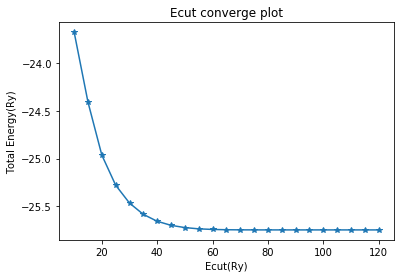

In [109]:
#analysis result  ecut=5 ERROR skip
total_e=[]
for ecut in range(10,121,5):
    %cd {ecut}
    total_energy = !grep -a "!    total energy              =" pw.out |  awk '{print $5}'
    total_e.append(float(total_energy[0]))
    %cd ..

plt.plot(range(10,121,5),total_e,'-*')
plt.xlabel('Ecut(Ry)')
plt.ylabel('Total Energy(Ry)')
plt.title('Ecut converge plot')
plt.show()

## <font color='blue'>Ecut_converged=60 Ry</font>

## test wstat n_pdep_eigen = 40   (Gamma only)
<pre>
For the converged value of ecut: 
Run wstat with n_pdep_eigen = 40 (10 * the number of electrons) 
</pre>

In [8]:
jm.cd_LOCAL_WORKING_DIR()
%mkdir wstat_test
%cd wstat_test

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
mkdir: cannot create directory ‘wstat_test’: File exists
/home/lan/Desktop/hBN_benchmark/rcc/wstat_test


In [9]:
%pwd

'/home/lan/Desktop/hBN_benchmark/rcc/wstat_test'

In [17]:
parameters = {'job_name': 'pw',
              'time': '00:20:00',
              'queue': 'broadwl',
              'nodes': 1,
              'ntasks_per_node': 1,
              'cpus_per_task': 2,
              'mem_per_cpu': 2000,
              'cmd': 'mpirun -np $NTASKS pw.x -i pw.in > pw.out'}

run pw.in first ecut=60 Ry  Gamma only

In [18]:
gs = GroundState(geom,xc="PBE",ecut=60)
gs.generateInputPW()
gs.downloadPseudopotentials()
Template(rcc_template_string,parameters).write('run_pw.sh')
#ignore @collect  the default collect is *  cp all from remote scratch to remote working 
%submit run_pw.sh


Generated file:  pw.in
Downloaded file:  B_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/B_ONCV_PBE-1.2.upf
Downloaded file:  N_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N_ONCV_PBE-1.2.upf
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  file:/home/lan/Desktop/hBN_benchmark/rcc/wstat_test/pw.in
Upload local  file:/home/lan/Desktop/hBN_benchmark/rcc/wstat_test/B_ONCV_PBE-1.2.upf
Upload local  file:/home/lan/Desktop/hBN_benchmark/rcc/wstat_test/wstat.in
Upload local  file:/home/lan/Desktop/hBN_benchmark/rcc/wstat_test/run_pw.sh
Upload local  file:/home/lan/Desktop/hBN_benchmark/rcc/wstat_test/run_wstat.sh
Upload local  file:/home/lan/Desktop/hBN_benchmark/rcc/wstat_test/N_ONCV_PBE-1.2.upf
JobID:3191678


In [23]:
#check pw.out normal termination at remote
remote_wstat_test_folder=ssh.get_REMOTE_WORKING_DIR() + '/wstat_test/'
print(ssh.cmd('cd '+remote_wstat_test_folder+'; grep "JOB DONE" pw.out'))
print(ssh.cmd('cd '+remote_wstat_test_folder+'; grep -a1 "Error" pw.out'))

   JOB DONE.




In [24]:
#check remote scratch files
scratch_wstat_test_scratch_folder = ssh.get_REMOTE_SCRATCH_DIR() + '/wstat_test/'
print(ssh.cmd('cd '+scratch_wstat_test_scratch_folder+'; ls'))

B_ONCV_PBE-1.2.upf
N_ONCV_PBE-1.2.upf
calc.save
pw.in
pw.out
run_pw.sh
run_wstat.sh
slurm-3191678.out
wstat.in



now remote scratch has the calc.save folder 

let's run wstat.in with n_pdep_eigen = 40

In [26]:
#confirm we are at wstat_test local folder
%pwd

'/home/lan/Desktop/hBN_benchmark/rcc/wstat_test'

In [27]:
parameters = {'job_name': 'wstat',
              'time': '01:30:00',
              'queue': 'broadwl',
              'nodes': 1,
              'ntasks_per_node': 1,
              'cpus_per_task': 14,
              'mem_per_cpu': 2000,
              'cmd': 'mpirun -np $NTASKS wstat.x -i wstat.in > wstat.out'}

In [28]:
data = {}
data["input_west"] = {}
data["input_west"]["qe_prefix"] = "calc"
data["input_west"]["west_prefix"] = "calc"
data["input_west"]["outdir"] = "./"
data["wstat_control"] = {}
data["wstat_control"]["wstat_calculation"] = "S"
data["wstat_control"]["n_pdep_eigen"] = 40
writeJsonFile("wstat.in",data)
Template(rcc_template_string,parameters).write('run_wstat.sh')
#ignore @collect will cp all files/folders from remote scratch to remote working dir 
%submit run_wstat.sh


File written :  wstat.in
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
OverwriteRemote file:/home/huangl1/simulation/wstat_test/run_wstat.sh
JobID:3191799


In [65]:
#check wstat.out normal termination at remote
remote_wstat_test_folder=ssh.get_REMOTE_WORKING_DIR() + '/wstat_test/'
print(ssh.cmd('cd '+remote_wstat_test_folder+'; grep "JOB DONE" wstat.out'))
print(ssh.cmd('cd '+remote_wstat_test_folder+'; grep -a1 "Error" wstat.out'))

   JOB DONE.




In [88]:
%pull

synchronizing remote:/home/huangl1/simulation  ->  local:/home/lan/Desktop/hBN_benchmark/rcc
Dowload remote dir:/home/huangl1/simulation/wstat_test/calc.wstat.save
Dowload remote dir:/home/huangl1/simulation/wstat_test/calc.save
Dowload remote file:/home/huangl1/simulation/wstat_test/pw.out
Dowload remote file:/home/huangl1/simulation/wstat_test/slurm-3191799.out
Dowload remote file:/home/huangl1/simulation/wstat_test/wstat.out
Dowload remote file:/home/huangl1/simulation/wstat_test/slurm-3191678.out
--------------------------- Local files change after pull -------------------------------
Files Added:
	/home/lan/Desktop/hBN_benchmark/rcc/wstat_test/pw.out
	/home/lan/Desktop/hBN_benchmark/rcc/wstat_test/slurm-3191799.out
	/home/lan/Desktop/hBN_benchmark/rcc/wstat_test/slurm-3191678.out
	/home/lan/Desktop/hBN_benchmark/rcc/wstat_test/wstat.out
	/home/lan/Desktop/hBN_benchmark/rcc/wstat_test/calc.wstat.save/Q000000001E000000040.json
	/home/lan/Desktop/hBN_benchmark/rcc/wstat_test/calc.wst

## test wfreq  (Gamma only)

Then run wfreq with: 

**n_refreq** —> this needs to be converged, start with n_refreq = 3 * Ry2eV / 0.1, and then increase it 

**n_imfreq** —> this needs to be converged, start with 64 and then increase to 128, 256, 512, ...

**n_lanczos** —> this needs to be converged, start with 10 and then increase to 20, 30, ... 

**n_pdep_eigen_to_use** —> this needs to be converged, start with the max possible = n_pdep_eigen from wstat and then reduce it, for instance 10 time the number of electrons, 9 times, 8 times, 7 times… 

**kmesh** --> this will be tested after tuning above parameters

qp_bandrange = [1,8] # compute GW for states the 4 occupied states and 4 empty bands —> this doesn’t need to be converged 

ecut_refreq = 3 —> this doesn’t need to be converged 

ecut_imfreq = ecut_rho —> = 4 * ecut —> this doesn’t need to be converged

n_secant_maxiter —> set it to 100 —> this doesn’t need to be converged  


Find optimal values for ecut, n_refreq, n_imfreq, n_lanczos, n_pdep_eigen_to_use. 

Once we have optimal values, we will freeze them, and then vary the vacuum (cell size), and obtain the reference plot. 


In [91]:
local_wstat_test_folder_content=ssh.get_LOCAL_WORKING_DIR() + '/wstat_test/*'
local_wstat_test_folder_content

'/home/lan/Desktop/hBN_benchmark/rcc/wstat_test/*'

In [70]:
Ry2eV = 13.6056980659
n_refreq = int(3 * Ry2eV / 0.1)
n_refreq

408

In [77]:
ecut_converged = 60
li_n_refreq = [50,100,150,200,250,272,300,350,408,500,600,700]
li_n_imfreq = [64,128,256,512,1024]
li_n_lanczos = [10,20,30,40,50]
li_n_pdep_eigen_to_use = [4*i for i in range(1,11)]

### 1. n_refreq converge

In [94]:
jm.cd_LOCAL_WORKING_DIR()
%mkdir test_wfreq
%cd test_wfreq

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq


creat files at local first

In [95]:
n_refreq = 272
n_lanczos = 30
n_imfreq = 256
n_pdep_eigen_to_use = 40
print('n_refreq,  n_imfreq,  n_lanczos,  n_pdep_eigen_to_use')
for n_refreq in li_n_refreq:
    print(n_refreq,n_imfreq,n_lanczos,n_pdep_eigen_to_use)
    #assign cur folder
    cur_folder='n_refreq_'+str(n_refreq)
    %mkdir {cur_folder}
    %cd {cur_folder}
    data = {}
    data["input_west"] = {}
    data["input_west"]["qe_prefix"] = "calc"
    data["input_west"]["west_prefix"] = "calc"
    data["input_west"]["outdir"] = "./"
    data["wstat_control"] = {}
    data["wstat_control"]["wstat_calculation"] = "S"
    data["wstat_control"]["n_pdep_eigen"] = 40
    #write wfreq.in
    data["wfreq_control"] = {}
    data["wfreq_control"]["wfreq_calculation"] = "XWGQ"
    data["wfreq_control"]["n_refreq"] = n_refreq
    data["wfreq_control"]["n_imfreq"] = n_imfreq
    data["wfreq_control"]["n_lanczos"] = n_lanczos
    data["wfreq_control"]["n_pdep_eigen_to_use"] = n_pdep_eigen_to_use
    data["wfreq_control"]["qp_bandrange"] = [1,8]
    data["wfreq_control"]["ecut_refreq"] = 3.0
    data["wfreq_control"]["ecut_imfreq"] = 4*ecut_converged
    data["wfreq_control"]["n_secant_maxiter"] = 100
    writeJsonFile("wfreq.in",data)
    #cp local_wstat_test_folder's content to cur_folder
    !cp -r  {local_wstat_test_folder_content} .
    %cd ..

n_refreq,  n_imfreq,  n_lanczos,  n_pdep_eigen_to_use
50 256 30 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_50

File written :  wfreq.in
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
100 256 30 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_100

File written :  wfreq.in
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
150 256 30 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_150

File written :  wfreq.in
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
200 256 30 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_200

File written :  wfreq.in
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
250 256 30 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_250

File written :  wfreq.in
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
272 256 30 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_272

File written :  wfreq.in
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
300 256 30 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_ref

submit wfreq job

In [99]:
parameters = {'job_name': 'wfreq',
              'time': '02:00:00',
              'queue': 'broadwl',
              'nodes': 1,
              'ntasks_per_node': 1,
              'cpus_per_task': 14,
              'mem_per_cpu': 2000,
              'cmd': 'mpirun -np $NTASKS wfreq.x -i wfreq.in > wfreq.out'}

In [100]:
jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq

for n_refreq in li_n_refreq:
    print('n_refreq',n_refreq)
    cur_folder='n_refreq_'+str(n_refreq)
    %cd {cur_folder}
    Template(rcc_template_string,parameters).write('run_wfreq.sh')
    %submit run_wfreq.sh @collect=wfreq.out,o*
    %cd ..

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 50
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_50
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  dir:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
JobID:3194114
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 100
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_100
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  file:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_100/run_wfreq.sh
JobID:3194162
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 150
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_150
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  file:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_150/run_wfreq.sh
JobID:319420

In [115]:
jm.view()

    JobID  | Status  |   Time   |    SubmitTime       |       Note
 -----------------------------Pending Jobs------------------------------
   3135402 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136672 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136675 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136736 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
 ----------------------------Finished  Jobs-----------------------------
   3169140 |  Done   |     0:00 | 2020-07-23 03:36:43 | /wstat_test |  
   3191678 |  Done   |     0:08 | 2020-07-24 14:39:59 | /wstat_test |  
   3191799 |  Done   |     0:18 | 2020-07-24 14:44:01 | /wstat_test |  
   3194114 |  Done   |     0:00 | 2020-07-24 15:46:07 | /test_wfreq/n_refreq_50 | wfreq.out,o* 
   3194162 |  Done   |     0:00 | 2020-07-24 15:46:12 | /test_wfreq/n_refreq_100 | wfreq.out,o* 
   3194205 |  Done   |     0:00 | 2020-07-

In [116]:
%pull

synchronizing remote:/home/huangl1/simulation  ->  local:/home/lan/Desktop/hBN_benchmark/rcc
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_refreq_408/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_refreq_408/o-eqp_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_refreq_408/wfreq.out
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_refreq_250/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_refreq_250/o-eqp_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_refreq_250/wfreq.out
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_refreq_300/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_refreq_300/o-eqp_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_refreq_300/wfreq.out
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_refreq_150/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_refreq_150

In [117]:
#check job terminate normal
jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq

for n_refreq in li_n_refreq:
    print('n_refreq',n_refreq)
    cur_folder='n_refreq_'+str(n_refreq)
    %cd {cur_folder}
    !grep 'JOB DONE' wfreq.out
    %cd ..

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 50
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_50
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 100
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_100
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 150
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_150
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 200
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_200
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 250
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_250
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 272
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_272
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 300
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_300
   JOB DON

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 50
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_50


/home/lan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 100
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_100
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 150
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_150
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 200
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_200
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 250
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_250
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 272
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_272
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 300
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_300
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 350
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_350
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq 408
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_refreq_408
/home/lan/Desktop/hBN_benchmark/rcc/test

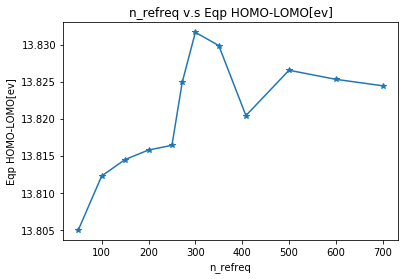

In [120]:
#plot  n_refreq
jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq

HOMO = 5
LOMO = 4
Eqp=[]

for n_refreq in li_n_refreq:
    print('n_refreq',n_refreq)
    cur_folder='n_refreq_'+str(n_refreq)
    %cd {cur_folder}
    #process o-eqp_K00001.tab
    tmp=pd.read_csv('o-eqp_K00001.tab',sep='      ', header=None,skiprows=[0])
    tmp.rename({0: 'band', 1: 'E0[eV]', 2:'EHF[eV]', 3:'Eqp[eV]',4:'Eqp-E0[eV]',5:'Sc_Eqp[eV]',6:'Width[eV]'}, axis=1, inplace=True)    
    Eqp_HOMO_LOMO=tmp.loc[HOMO-1,'Eqp[eV]'] - tmp.loc[LOMO-1,'Eqp[eV]'] 
    Eqp.append(Eqp_HOMO_LOMO)
    %cd ..

plt.plot(li_n_refreq,Eqp,'-*')
plt.xlabel('n_refreq')
plt.ylabel('Eqp HOMO-LOMO[ev]')
plt.title('n_refreq v.s Eqp HOMO-LOMO[ev]')
plt.show()

## <font color='blue'>converged n_refreq=600</font>

### 2. n_imfreq converge

In [122]:
local_wstat_test_folder_content=ssh.get_LOCAL_WORKING_DIR() + '/wstat_test/*'


jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq


ecut_converged = 60
li_n_refreq = [50,100,150,200,250,272,300,350,408,500,600,700]
li_n_imfreq = [64,128,256,512,1024]
li_n_lanczos = [10,20,30,40,50]
li_n_pdep_eigen_to_use = [4*i for i in range(1,11)]


n_refreq = 272
n_lanczos = 30
n_imfreq = 256
n_pdep_eigen_to_use = 40


parameters = {'job_name': 'wfreq',
              'time': '02:00:00',
              'queue': 'broadwl',
              'nodes': 1,
              'ntasks_per_node': 1,
              'cpus_per_task': 14,
              'mem_per_cpu': 2000,
              'cmd': 'mpirun -np $NTASKS wfreq.x -i wfreq.in > wfreq.out'}


print('n_refreq,  n_imfreq,  n_lanczos,  n_pdep_eigen_to_use')
for n_imfreq in li_n_imfreq:
    print(n_refreq,n_imfreq,n_lanczos,n_pdep_eigen_to_use)
    #assign cur folder
    cur_folder='n_imfreq_'+str(n_imfreq)
    %mkdir {cur_folder}
    %cd {cur_folder}
    data = {}
    data["input_west"] = {}
    data["input_west"]["qe_prefix"] = "calc"
    data["input_west"]["west_prefix"] = "calc"
    data["input_west"]["outdir"] = "./"
    data["wstat_control"] = {}
    data["wstat_control"]["wstat_calculation"] = "S"
    data["wstat_control"]["n_pdep_eigen"] = 40
    #write wfreq.in
    data["wfreq_control"] = {}
    data["wfreq_control"]["wfreq_calculation"] = "XWGQ"
    data["wfreq_control"]["n_refreq"] = n_refreq
    data["wfreq_control"]["n_imfreq"] = n_imfreq
    data["wfreq_control"]["n_lanczos"] = n_lanczos
    data["wfreq_control"]["n_pdep_eigen_to_use"] = n_pdep_eigen_to_use
    data["wfreq_control"]["qp_bandrange"] = [1,8]
    data["wfreq_control"]["ecut_refreq"] = 3.0
    data["wfreq_control"]["ecut_imfreq"] = 4*ecut_converged
    data["wfreq_control"]["n_secant_maxiter"] = 100
    writeJsonFile("wfreq.in",data)
    #cp local_wstat_test_folder's content to cur_folder
    !cp -r  {local_wstat_test_folder_content} .
    Template(rcc_template_string,parameters).write('run_wfreq.sh')
    %submit run_wfreq.sh @collect=wfreq.out,o*
    %cd ..

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq,  n_imfreq,  n_lanczos,  n_pdep_eigen_to_use
272 64 30 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_64

File written :  wfreq.in
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  dir:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_64
JobID:3196120
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
272 128 30 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_128

File written :  wfreq.in
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  dir:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_128
JobID:3196121
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
272 256 30 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_256

File written :  wfreq.in
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  rem

In [134]:
jm.view()

    JobID  | Status  |   Time   |    SubmitTime       |       Note
 -----------------------------Pending Jobs------------------------------
   3135402 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136672 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136675 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136736 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
 ----------------------------Finished  Jobs-----------------------------
   3169140 |  Done   |     0:00 | 2020-07-23 03:36:43 | /wstat_test |  
   3191678 |  Done   |     0:08 | 2020-07-24 14:39:59 | /wstat_test |  
   3191799 |  Done   |     0:18 | 2020-07-24 14:44:01 | /wstat_test |  
   3194114 |  Done   |     0:00 | 2020-07-24 15:46:07 | /test_wfreq/n_refreq_50 | wfreq.out,o* 
   3194162 |  Done   |     0:00 | 2020-07-24 15:46:12 | /test_wfreq/n_refreq_100 | wfreq.out,o* 
   3194205 |  Done   |     0:00 | 2020-07-

In [135]:
%pull

synchronizing remote:/home/huangl1/simulation  ->  local:/home/lan/Desktop/hBN_benchmark/rcc
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_imfreq_1024/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_imfreq_1024/o-eqp_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_imfreq_1024/wfreq.out
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_imfreq_512/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_imfreq_512/o-eqp_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_imfreq_512/wfreq.out
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_imfreq_256/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_imfreq_256/o-eqp_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_imfreq_256/wfreq.out
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_imfreq_128/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_imfreq_

In [136]:
#check job terminate normal
jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq

for n_imfreq in li_n_imfreq:
    print('n_imfreq',n_imfreq)
    cur_folder='n_imfreq_'+str(n_imfreq)
    %cd {cur_folder}
    !grep 'JOB DONE' wfreq.out
    %cd ..

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_imfreq 64
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_64
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_imfreq 128
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_128
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_imfreq 256
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_256
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_imfreq 512
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_512
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_imfreq 1024
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_1024
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq


Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_imfreq 64
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_64
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_imfreq 128
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_128
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_imfreq 256
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_256
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_imfreq 512


/home/lan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_512
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_imfreq 1024
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_imfreq_1024
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq


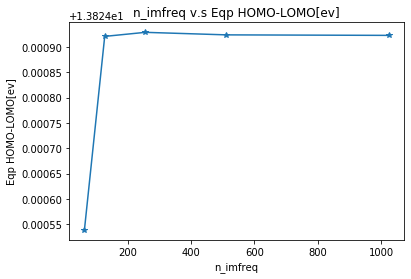

In [138]:
#plot  n_imfreq
jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq

HOMO = 5
LOMO = 4
Eqp=[]

for n_imfreq in li_n_imfreq:
    print('n_imfreq',n_imfreq)
    cur_folder='n_imfreq_'+str(n_imfreq)
    %cd {cur_folder}
    #process o-eqp_K00001.tab
    tmp=pd.read_csv('o-eqp_K00001.tab',sep='      ', header=None,skiprows=[0])
    tmp.rename({0: 'band', 1: 'E0[eV]', 2:'EHF[eV]', 3:'Eqp[eV]',4:'Eqp-E0[eV]',5:'Sc_Eqp[eV]',6:'Width[eV]'}, axis=1, inplace=True)    
    Eqp_HOMO_LOMO=tmp.loc[HOMO-1,'Eqp[eV]'] - tmp.loc[LOMO-1,'Eqp[eV]'] 
    Eqp.append(Eqp_HOMO_LOMO)
    %cd ..

plt.plot(li_n_imfreq,Eqp,'-*')
plt.xlabel('n_imfreq')
plt.ylabel('Eqp HOMO-LOMO[ev]')
plt.title('n_imfreq v.s Eqp HOMO-LOMO[ev]')
plt.show()

## <font color='blue'>converged n_imfreq=256</font>

### 3. n_lanczos  converge

In [141]:
local_wstat_test_folder_content=ssh.get_LOCAL_WORKING_DIR() + '/wstat_test/*'


jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq


ecut_converged = 60
li_n_refreq = [50,100,150,200,250,272,300,350,408,500,600,700]
li_n_imfreq = [64,128,256,512,1024]
li_n_lanczos = [10,20,30,40,50]
li_n_pdep_eigen_to_use = [4*i for i in range(1,11)]


n_refreq = 272
n_lanczos = 30
n_imfreq = 256
n_pdep_eigen_to_use = 40


parameters = {'job_name': 'wfreq',
              'time': '02:00:00',
              'queue': 'broadwl',
              'nodes': 1,
              'ntasks_per_node': 1,
              'cpus_per_task': 14,
              'mem_per_cpu': 2000,
              'cmd': 'mpirun -np $NTASKS wfreq.x -i wfreq.in > wfreq.out'}


print('n_refreq,  n_imfreq,  n_lanczos,  n_pdep_eigen_to_use')
for n_lanczos in li_n_lanczos:
    print(n_refreq,n_imfreq,n_lanczos,n_pdep_eigen_to_use)
    #assign cur folder
    cur_folder='n_lanczos_'+str(n_lanczos)
    %mkdir {cur_folder}
    %cd {cur_folder}
    data = {}
    data["input_west"] = {}
    data["input_west"]["qe_prefix"] = "calc"
    data["input_west"]["west_prefix"] = "calc"
    data["input_west"]["outdir"] = "./"
    data["wstat_control"] = {}
    data["wstat_control"]["wstat_calculation"] = "S"
    data["wstat_control"]["n_pdep_eigen"] = 40
    #write wfreq.in
    data["wfreq_control"] = {}
    data["wfreq_control"]["wfreq_calculation"] = "XWGQ"
    data["wfreq_control"]["n_refreq"] = n_refreq
    data["wfreq_control"]["n_imfreq"] = n_imfreq
    data["wfreq_control"]["n_lanczos"] = n_lanczos
    data["wfreq_control"]["n_pdep_eigen_to_use"] = n_pdep_eigen_to_use
    data["wfreq_control"]["qp_bandrange"] = [1,8]
    data["wfreq_control"]["ecut_refreq"] = 3.0
    data["wfreq_control"]["ecut_imfreq"] = 4*ecut_converged
    data["wfreq_control"]["n_secant_maxiter"] = 100
    writeJsonFile("wfreq.in",data)
    #cp local_wstat_test_folder's content to cur_folder
    !cp -r  {local_wstat_test_folder_content} .
    Template(rcc_template_string,parameters).write('run_wfreq.sh')
    %submit run_wfreq.sh @collect=wfreq.out,o*
    %cd ..

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq,  n_imfreq,  n_lanczos,  n_pdep_eigen_to_use
272 256 10 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_10

File written :  wfreq.in
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  dir:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_10
JobID:3196260
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
272 256 20 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_20

File written :  wfreq.in
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  dir:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_20
JobID:3196261
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
272 256 30 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_30

File written :  wfreq.in
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  

In [146]:
jm.view()

    JobID  | Status  |   Time   |    SubmitTime       |       Note
 -----------------------------Pending Jobs------------------------------
   3135402 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136672 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136675 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136736 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
 ----------------------------Finished  Jobs-----------------------------
   3169140 |  Done   |     0:00 | 2020-07-23 03:36:43 | /wstat_test |  
   3191678 |  Done   |     0:08 | 2020-07-24 14:39:59 | /wstat_test |  
   3191799 |  Done   |     0:18 | 2020-07-24 14:44:01 | /wstat_test |  
   3194114 |  Done   |     0:00 | 2020-07-24 15:46:07 | /test_wfreq/n_refreq_50 | wfreq.out,o* 
   3194162 |  Done   |     0:00 | 2020-07-24 15:46:12 | /test_wfreq/n_refreq_100 | wfreq.out,o* 
   3194205 |  Done   |     0:00 | 2020-07-

In [148]:
%pull

synchronizing remote:/home/huangl1/simulation  ->  local:/home/lan/Desktop/hBN_benchmark/rcc
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_lanczos_50/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_lanczos_50/o-eqp_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_lanczos_50/wfreq.out
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_lanczos_30/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_lanczos_30/o-eqp_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_lanczos_30/wfreq.out
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_lanczos_10/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_lanczos_10/o-eqp_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_lanczos_10/wfreq.out
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_lanczos_20/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_lanczos_20

In [149]:
#check job terminate normal
jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq

for n_lanczos in li_n_lanczos:
    print('n_lanczos',n_lanczos)
    cur_folder='n_lanczos_'+str(n_lanczos)
    %cd {cur_folder}
    !grep 'JOB DONE' wfreq.out
    %cd ..

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_lanczos 10
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_10
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_lanczos 20
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_20
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_lanczos 30
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_30
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_lanczos 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_40
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_lanczos 50
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_50
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq


Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_lanczos 10
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_10
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_lanczos 20
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_20
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_lanczos 30
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_30
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_lanczos 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_40


/home/lan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_lanczos 50
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_lanczos_50
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq


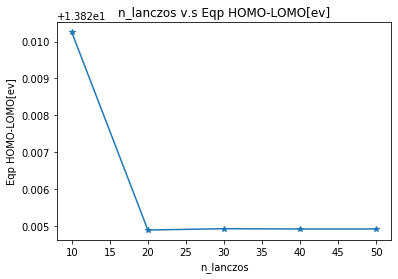

In [150]:
#plot  n_lanczos
jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq

HOMO = 5
LOMO = 4
Eqp=[]

for n_lanczos in li_n_lanczos:
    print('n_lanczos',n_lanczos)
    cur_folder='n_lanczos_'+str(n_lanczos)
    %cd {cur_folder}
    #process o-eqp_K00001.tab
    tmp=pd.read_csv('o-eqp_K00001.tab',sep='      ', header=None,skiprows=[0])
    tmp.rename({0: 'band', 1: 'E0[eV]', 2:'EHF[eV]', 3:'Eqp[eV]',4:'Eqp-E0[eV]',5:'Sc_Eqp[eV]',6:'Width[eV]'}, axis=1, inplace=True)    
    Eqp_HOMO_LOMO=tmp.loc[HOMO-1,'Eqp[eV]'] - tmp.loc[LOMO-1,'Eqp[eV]'] 
    Eqp.append(Eqp_HOMO_LOMO)
    %cd ..

plt.plot(li_n_lanczos,Eqp,'-*')
plt.xlabel('n_lanczos')
plt.ylabel('Eqp HOMO-LOMO[ev]')
plt.title('n_lanczos v.s Eqp HOMO-LOMO[ev]')
plt.show()

## <font color='blue'>converged n_lanczos=30</font> 

### 4. n_pdep_eigen_to_use  converge

In [151]:
local_wstat_test_folder_content=ssh.get_LOCAL_WORKING_DIR() + '/wstat_test/*'


jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq


ecut_converged = 60
li_n_refreq = [50,100,150,200,250,272,300,350,408,500,600,700]
li_n_imfreq = [64,128,256,512,1024]
li_n_lanczos = [10,20,30,40,50]
li_n_pdep_eigen_to_use = [4*i for i in range(1,11)]


n_refreq = 272
n_lanczos = 30
n_imfreq = 256
n_pdep_eigen_to_use = 40


parameters = {'job_name': 'wfreq',
              'time': '02:00:00',
              'queue': 'broadwl',
              'nodes': 1,
              'ntasks_per_node': 1,
              'cpus_per_task': 14,
              'mem_per_cpu': 2000,
              'cmd': 'mpirun -np $NTASKS wfreq.x -i wfreq.in > wfreq.out'}


print('n_refreq,  n_imfreq,  n_lanczos,  n_pdep_eigen_to_use')
for n_pdep_eigen_to_use in li_n_pdep_eigen_to_use:
    print(n_refreq,n_imfreq,n_lanczos,n_pdep_eigen_to_use)
    #assign cur folder
    cur_folder='n_pdep_eigen_to_use_'+str(n_pdep_eigen_to_use)
    %mkdir {cur_folder}
    %cd {cur_folder}
    data = {}
    data["input_west"] = {}
    data["input_west"]["qe_prefix"] = "calc"
    data["input_west"]["west_prefix"] = "calc"
    data["input_west"]["outdir"] = "./"
    data["wstat_control"] = {}
    data["wstat_control"]["wstat_calculation"] = "S"
    data["wstat_control"]["n_pdep_eigen"] = 40
    #write wfreq.in
    data["wfreq_control"] = {}
    data["wfreq_control"]["wfreq_calculation"] = "XWGQ"
    data["wfreq_control"]["n_refreq"] = n_refreq
    data["wfreq_control"]["n_imfreq"] = n_imfreq
    data["wfreq_control"]["n_lanczos"] = n_lanczos
    data["wfreq_control"]["n_pdep_eigen_to_use"] = n_pdep_eigen_to_use
    data["wfreq_control"]["qp_bandrange"] = [1,8]
    data["wfreq_control"]["ecut_refreq"] = 3.0
    data["wfreq_control"]["ecut_imfreq"] = 4*ecut_converged
    data["wfreq_control"]["n_secant_maxiter"] = 100
    writeJsonFile("wfreq.in",data)
    #cp local_wstat_test_folder's content to cur_folder
    !cp -r  {local_wstat_test_folder_content} .
    Template(rcc_template_string,parameters).write('run_wfreq.sh')
    %submit run_wfreq.sh @collect=wfreq.out,o*
    %cd ..

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_refreq,  n_imfreq,  n_lanczos,  n_pdep_eigen_to_use
272 256 30 4
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_4

File written :  wfreq.in
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  dir:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_4
JobID:3196847
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
272 256 30 8
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_8

File written :  wfreq.in
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  dir:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_8
JobID:3196848
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
272 256 30 12
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_12

File written :  wfreq.in
synchronizing loc

In [155]:
jm.view()

    JobID  | Status  |   Time   |    SubmitTime       |       Note
 -----------------------------Pending Jobs------------------------------
   3135402 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136672 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136675 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136736 | Pending |     0:00 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
 ----------------------------Finished  Jobs-----------------------------
   3169140 |  Done   |     0:00 | 2020-07-23 03:36:43 | /wstat_test |  
   3191678 |  Done   |     0:08 | 2020-07-24 14:39:59 | /wstat_test |  
   3191799 |  Done   |     0:18 | 2020-07-24 14:44:01 | /wstat_test |  
   3194114 |  Done   |     0:00 | 2020-07-24 15:46:07 | /test_wfreq/n_refreq_50 | wfreq.out,o* 
   3194162 |  Done   |     0:00 | 2020-07-24 15:46:12 | /test_wfreq/n_refreq_100 | wfreq.out,o* 
   3194205 |  Done   |     0:00 | 2020-07-

In [156]:
%pull

synchronizing remote:/home/huangl1/simulation  ->  local:/home/lan/Desktop/hBN_benchmark/rcc
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_pdep_eigen_to_use_32/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_pdep_eigen_to_use_32/o-eqp_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_pdep_eigen_to_use_32/wfreq.out
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_pdep_eigen_to_use_28/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_pdep_eigen_to_use_28/o-eqp_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_pdep_eigen_to_use_28/wfreq.out
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_pdep_eigen_to_use_36/o-ehf_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_pdep_eigen_to_use_36/o-eqp_K00001.tab
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_pdep_eigen_to_use_36/wfreq.out
Dowload remote file:/home/huangl1/simulation/test_wfreq/n_pdep_e

In [157]:
#check job terminate normal
jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq

for n_pdep_eigen_to_use in li_n_pdep_eigen_to_use:
    print('n_pdep_eigen_to_use',n_pdep_eigen_to_use)
    cur_folder='n_pdep_eigen_to_use_'+str(n_pdep_eigen_to_use)
    %cd {cur_folder}
    !grep 'JOB DONE' wfreq.out
    %cd ..

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 4
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_4
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 8
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_8
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 12
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_12
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 16
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_16
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 20
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_20
   JOB DONE.
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 24
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_24
   JOB DONE.
/home/lan/De

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 4
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_4
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 8
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_8
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 12
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_12
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 16
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_16


/home/lan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 20
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_20
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 24
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_24
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 28
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_28
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 32
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_32
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 36
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_36
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
n_pdep_eigen_to_use 40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/n_pdep_eigen_to_use_40
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq


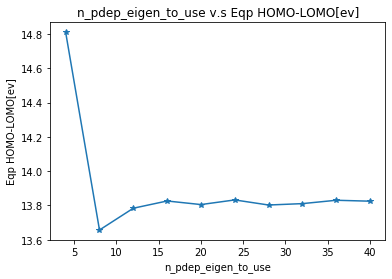

In [160]:
#plot  n_lanczos
jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq

HOMO = 5
LOMO = 4
Eqp=[]

for n_pdep_eigen_to_use in li_n_pdep_eigen_to_use:
    print('n_pdep_eigen_to_use',n_pdep_eigen_to_use)
    cur_folder='n_pdep_eigen_to_use_'+str(n_pdep_eigen_to_use)
    %cd {cur_folder}
    #process o-eqp_K00001.tab
    tmp=pd.read_csv('o-eqp_K00001.tab',sep='      ', header=None,skiprows=[0])
    tmp.rename({0: 'band', 1: 'E0[eV]', 2:'EHF[eV]', 3:'Eqp[eV]',4:'Eqp-E0[eV]',5:'Sc_Eqp[eV]',6:'Width[eV]'}, axis=1, inplace=True)    
    Eqp_HOMO_LOMO=tmp.loc[HOMO-1,'Eqp[eV]'] - tmp.loc[LOMO-1,'Eqp[eV]'] 
    Eqp.append(Eqp_HOMO_LOMO)
    %cd ..

plt.plot(li_n_pdep_eigen_to_use,Eqp,'-*')
plt.xlabel('n_pdep_eigen_to_use')
plt.ylabel('Eqp HOMO-LOMO[ev]')
plt.title('n_pdep_eigen_to_use v.s Eqp HOMO-LOMO[ev]')
plt.show()

## <font color='blue'>converged n_pdep_eigen_to_use=16</font> 

# <font color='blue'>summary of wfreq converge result using Gamma only: </font>
 

**n_refreq** —>  600

**n_imfreq** —>  256

**n_lanczos** —> 30

**n_pdep_eigen_to_use** —> 16


qp_bandrange = [1,8] # compute GW for states the 4 occupied states and 4 empty bands 

ecut_refreq = 3 —> this doesn’t need to be converged 

ecut_imfreq = ecut_rho —> = 4 * ecut —> this doesn’t need to be converged

n_secant_maxiter —> set it to 100 —> this doesn’t need to be converged  


Once we have optimal values, we will freeze them, and then vary the vacuum (cell size), and obtain the reference plot.


### 5. Kmesh  converge

get the relaxed geom first

In [21]:
geom = Geometry()
geom.addSpecies( "B", "http://www.quantum-simulation.org/potentials/sg15_oncv/upf/B_ONCV_PBE-1.2.upf")
geom.addSpecies( "N", "http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N_ONCV_PBE-1.2.upf")
geom.setCell(a1=(4.720848803 , -0.000000504 , -0.000000126), a2=(-2.360424838 ,  4.088374745 , -0.000000007), a3=(-0.000000206 , -0.000000131 ,  8.878321379))
geom.addAtom('B', (-0.000000875 ,  2.725583229 ,  4.439160632))
geom.addAtom('N', (2.360424634 ,  1.362790881  , 4.439160615))
geom.view(style='stick',ix=2,iy=2)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

pw step

In [164]:
jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq


ecut_converged = 60
 
n_refreq = 600
n_lanczos = 30
n_imfreq = 256
n_pdep_eigen_to_use = 32

li_kmesh = [2,4,6,8,10,12,14,16,18]

parameters = {'job_name': 'wfreq',
              'time': '02:00:00',
              'queue': 'broadwl',
              'nodes': 1,
              'ntasks_per_node': 1,
              'cpus_per_task': 8,
              'mem_per_cpu': 2000,
              'cmd': 'mpirun -np $NTASKS pw.x -i pw.in > pw.out'}


 
for kmesh in li_kmesh:
    
    #assign cur folder
    cur_folder='kmesh_'+str(kmesh)
    %mkdir {cur_folder}
    %cd {cur_folder}
    
    gs = GroundState(geom,xc="PBE",ecut=ecut_converged)
    gs.setNempty(nempty=0)
    gs.setKmesh((kmesh,kmesh,1))
    gs.generateInputPW()
    gs.downloadPseudopotentials()
     
    Template(rcc_template_string,parameters).write('run_pw.sh')
    %submit run_pw.sh
    
    %cd ..

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/kmesh_2

Generated file:  pw.in
Downloaded file:  B_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/B_ONCV_PBE-1.2.upf
Downloaded file:  N_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N_ONCV_PBE-1.2.upf
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  dir:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/kmesh_2
JobID:3196944
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/kmesh_4

Generated file:  pw.in
Downloaded file:  B_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/B_ONCV_PBE-1.2.upf
Downloaded file:  N_ONCV_PBE-1.2.upf , from url:  http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N

In [33]:
jm.view()

    JobID  | Status  |   Time   |    SubmitTime       |       Note
 -----------------------------Pending Jobs------------------------------
   3208998 | Pending |     0:00 | 2020-07-26 08:48:29 | Cannot find JobInfo in log 
 -----------------------------Running Jobs------------------------------
   3197077 | Running | 1-02:00:36 | 2020-07-24 20:13:06 | /test_wfreq/kmesh_18 | wstat.out 
   3197075 | Running | 1-02:06:36 | 2020-07-24 20:12:43 | /test_wfreq/kmesh_16 | wstat.out 
   3197074 | Running | 1-02:09:36 | 2020-07-24 20:12:26 | /test_wfreq/kmesh_14 | wstat.out 
   3197073 | Running | 1-03:02:38 | 2020-07-24 20:12:12 | /test_wfreq/kmesh_12 | wstat.out 
   3136675 | Running | 1-03:02:38 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   3136672 | Running | 1-03:18:38 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
 ----------------------------Finished  Jobs-----------------------------
   3135402 |  Done   | 14:12:20 | 2020-07-22 21:52:30 | Cannot find JobInfo in log 
   313

In [34]:
#check remote scratch job termination status
for kmesh in li_kmesh:
    remote_scratch_kmesh = ssh.get_REMOTE_SCRATCH_DIR() + '/test_wfreq/kmesh_' + str(kmesh)
    print(kmesh,ssh.cmd('cd '+remote_scratch_kmesh+'; grep "JOB DONE" pw.out'))

2    JOB DONE.

4    JOB DONE.

6    JOB DONE.

8    JOB DONE.

10    JOB DONE.

12    JOB DONE.

14    JOB DONE.

16    JOB DONE.

18    JOB DONE.



wstat step

In [183]:
jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq

li_kmesh = [2,4,6,8,10,12,14,16,18]
times = ['02:00:00','04:00:00','08:00:00','16:00:00','35:00:00','35:00:00','35:00:00','35:00:00','35:00:00']

parameters = {'job_name': 'wstat',
              'time': '02:00:00',
              'queue': 'broadwl',
              'nodes': 2,
              'ntasks_per_node': 1,
              'cpus_per_task': 28,
              'mem_per_cpu': 2000,
              'cmd': 'mpirun -np $NTASKS wstat.x -i wstat.in > wstat.out'}

 
for kmesh,time in zip(li_kmesh,times):
    #assign cur folder
    cur_folder='kmesh_'+str(kmesh)
    %cd {cur_folder}
    data = {}
    data["input_west"] = {}
    data["input_west"]["qe_prefix"] = "calc"
    data["input_west"]["west_prefix"] = "calc"
    data["input_west"]["outdir"] = "./"
    data["wstat_control"] = {}
    data["wstat_control"]["wstat_calculation"] = "S"
    data["wstat_control"]["n_pdep_eigen"] = 40
    writeJsonFile("wstat.in",data)
    parameters['time'] = time
    Template(rcc_template_string,parameters).write('run_wstat.sh')
    %submit run_wstat.sh @collect = wstat.out  
    %cd ..

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/kmesh_2

File written :  wstat.in
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  file:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/kmesh_2/run_wstat.sh
Upload local  file:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/kmesh_2/wstat.in
JobID:3197065
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/kmesh_4

File written :  wstat.in
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
Upload local  file:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/kmesh_4/run_wstat.sh
Upload local  file:/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/kmesh_4/wstat.in
JobID:3197068
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/kmesh_6

File written 

In [5]:
jm.view()

    JobID  | Status  |   Time   |    SubmitTime       |       Note
 -----------------------------Pending Jobs------------------------------
   3223190 | Pending |     0:00 | 2020-07-27 21:33:54 | Cannot find JobInfo in log 
   3223191 | Pending |     0:00 | 2020-07-27 21:33:54 | Cannot find JobInfo in log 
   3223193 | Pending |     0:00 | 2020-07-27 21:33:54 | Cannot find JobInfo in log 


In [4]:
#check remote scratch job termination status
li_kmesh = [2,4,6,8,10,12,14,16,18]
for kmesh in li_kmesh:
    remote_scratch_kmesh = ssh.get_REMOTE_SCRATCH_DIR() + '/test_wfreq/kmesh_' + str(kmesh)
    print(kmesh,ssh.cmd('cd '+remote_scratch_kmesh+'; grep "JOB DONE" wstat.out'))

2    JOB DONE.

4    JOB DONE.

6    JOB DONE.

8    JOB DONE.

10    JOB DONE.

12 
14 
16 
18 


Since the 12 14 16 18 kmesh jobs are out of walltime, change wstat.in at local data["wstat_control"]["wstat_calculation"] = "R"

resubmit for kmesh 12 14 16 18

In [7]:
jm.cd_LOCAL_WORKING_DIR()
%cd test_wfreq

li_kmesh = [12,14,16,18]
times = ['35:00:00','35:00:00','35:00:00','35:00:00']

parameters = {'job_name': 'wstat',
              'time': '02:00:00',
              'queue': 'broadwl',
              'nodes': 2,
              'ntasks_per_node': 1,
              'cpus_per_task': 28,
              'mem_per_cpu': 2000,
              'cmd': 'mpirun -np $NTASKS wstat.x -i wstat.in > wstat.out'}

 
for kmesh,time in zip(li_kmesh,times):
    #assign cur folder
    cur_folder='kmesh_'+str(kmesh)
    %cd {cur_folder}
    data = {}
    data["input_west"] = {}
    data["input_west"]["qe_prefix"] = "calc"
    data["input_west"]["west_prefix"] = "calc"
    data["input_west"]["outdir"] = "./"
    data["wstat_control"] = {}
    data["wstat_control"]["wstat_calculation"] = "R"
    data["wstat_control"]["n_pdep_eigen"] = 40
    writeJsonFile("wstat.in",data)
    parameters['time'] = time
    Template(rcc_template_string,parameters).write('run_wstat.sh')
    %submit run_wstat.sh @collect = wstat.out  
    %cd ..

Change directory to LOCAL_WORKING_DIR:/home/lan/Desktop/hBN_benchmark/rcc
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/kmesh_12

File written :  wstat.in
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
OverwriteRemote file:/home/huangl1/simulation/test_wfreq/kmesh_18/wstat.in
OverwriteRemote file:/home/huangl1/simulation/test_wfreq/kmesh_16/wstat.in
OverwriteRemote file:/home/huangl1/simulation/test_wfreq/kmesh_12/wstat.in
OverwriteRemote file:/home/huangl1/simulation/test_wfreq/kmesh_14/wstat.in
JobID:3223648
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq/kmesh_14

File written :  wstat.in
synchronizing local:/home/lan/Desktop/hBN_benchmark/rcc  ->  remote:/home/huangl1/simulation
OverwriteRemote file:/home/huangl1/simulation/test_wfreq/kmesh_14/wstat.in
JobID:3223649
/home/lan/Desktop/hBN_benchmark/rcc/test_wfreq
/home/lan/Desktop/hBN_benchmark/

In [ ]:
%close